# ScRNA-Seq of human bone marrow cells from Oetjen et al.

Inspired by the work of [Luecken, MD. et al.](https://www.nature.com/articles/s41592-021-01336-8#Sec35)
<br>Code: https://github.com/theislab/scib-reproducibility/tree/main 
<br>
<br>Data from [Oetjen, KA. et al.](https://insight.jci.org/articles/view/124928)
<br>Data: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3396161 

In [1]:
# Import packages
import scanpy as sc
import numpy as np
import scipy as sp
from scipy.sparse import csr_matrix, issparse
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
from functions import data_preprocessing as dp
import seaborn as sb
import random
import warnings
import logging
import json

In [2]:
# Path of data
file_base = '../../../../data/raw/immune_cells/bone_marrow_human/GSM3396161_A/'
count_file_end = 'GSM3396161_matrix_A.mtx.gz'
gene_data_end = 'GSM3396161_genes_A.tsv.gz'
barcode_data_end = 'GSM3396161_barcodes_A.tsv.gz'

count_data = file_base+count_file_end
gene_data = file_base+gene_data_end
barcode_data = file_base+barcode_data_end

# Read data
adata = dp.read_sc_data(count_data, gene_data, barcode_data)

adata.var_names_make_unique()

In [3]:
print(adata.X.shape)
print(adata)

(2994, 33694)
AnnData object with n_obs × n_vars = 2994 × 33694
    var: 'gene_id'


In [4]:
adata.var.head()

,gene_id
gene_symbol,
RP11-34P13.3,ENSG00000243485
FAM138A,ENSG00000237613
OR4F5,ENSG00000186092
RP11-34P13.7,ENSG00000238009
RP11-34P13.8,ENSG00000239945


## Preprocessing

In [3]:
# Add QC metrics to adata
adata = dp.QC().QC_metric_calc(adata)
print(adata.obs)

                    n_counts  log_n_counts  n_genes  log_n_genes  \
barcode                                                            
AAACCTGCAAGTAATG-1   10568.0      9.265680      519     6.253829   
AAACCTGCAGCGAACA-1    6379.0      8.760923     1862     7.529943   
AAACCTGCATGTCCTC-1    4172.0      8.336390     1082     6.987490   
AAACCTGGTCGACTGC-1    6608.0      8.796187     1618     7.389564   
AAACCTGGTCGCTTCT-1    5034.0      8.524169     1413     7.254178   
...                      ...           ...      ...          ...   
TTTGGTTGTTAAAGAC-1    3917.0      8.273336      960     6.867974   
TTTGGTTTCCACGCAG-1    3971.0      8.287025     1143     7.042286   
TTTGTCAAGCAAATCA-1    4868.0      8.490644     1062     6.968850   
TTTGTCACAGGGTATG-1    9796.0      9.189832      524     6.263398   
TTTGTCATCAGGCCCA-1    3966.0      8.285766      882     6.783325   

                    pct_counts_in_top_20_genes   mt_frac  
barcode                                                 

In [4]:
qc_adata = dp.QC().QC_filter_outliers(adata,5)

Number of cells before QC filtering: 2994
Number of cells removed by log_n_genes filtering: 66
Number of cells removed by log_n_counts filtering: 39
Number of cells removed by pct_counts_in_top_20_genes filtering: 620
Number of cells removed by mt_frac filtering: 22
Number of cells post QC filtering: 2311
Number of genes before filtering: 33694
Number of genes after filtering so theres min 20 unique cells per gene: 12438


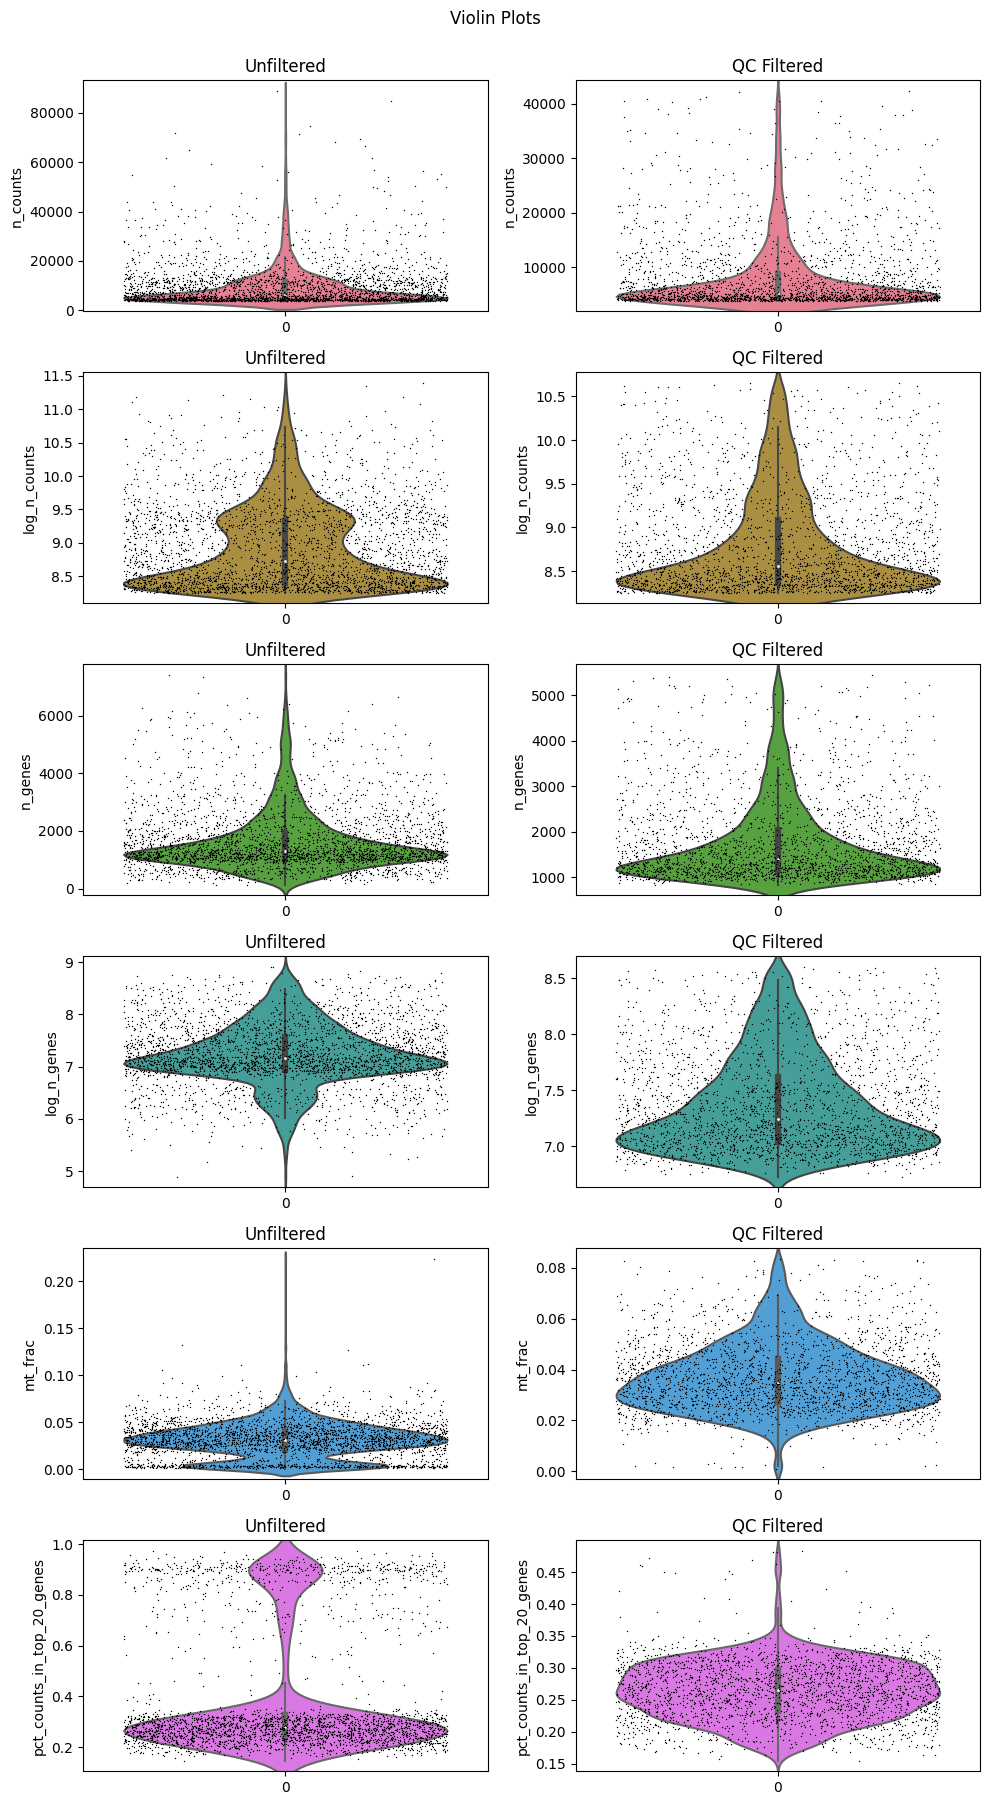

In [5]:
dp.EDA().ViolinJitter([adata, qc_adata], 
                        y_rows=['n_counts','log_n_counts','n_genes','log_n_genes','mt_frac','pct_counts_in_top_20_genes'], 
                        title="Violin Plots",
                        subtitle=["Unfiltered", "QC Filtered"])

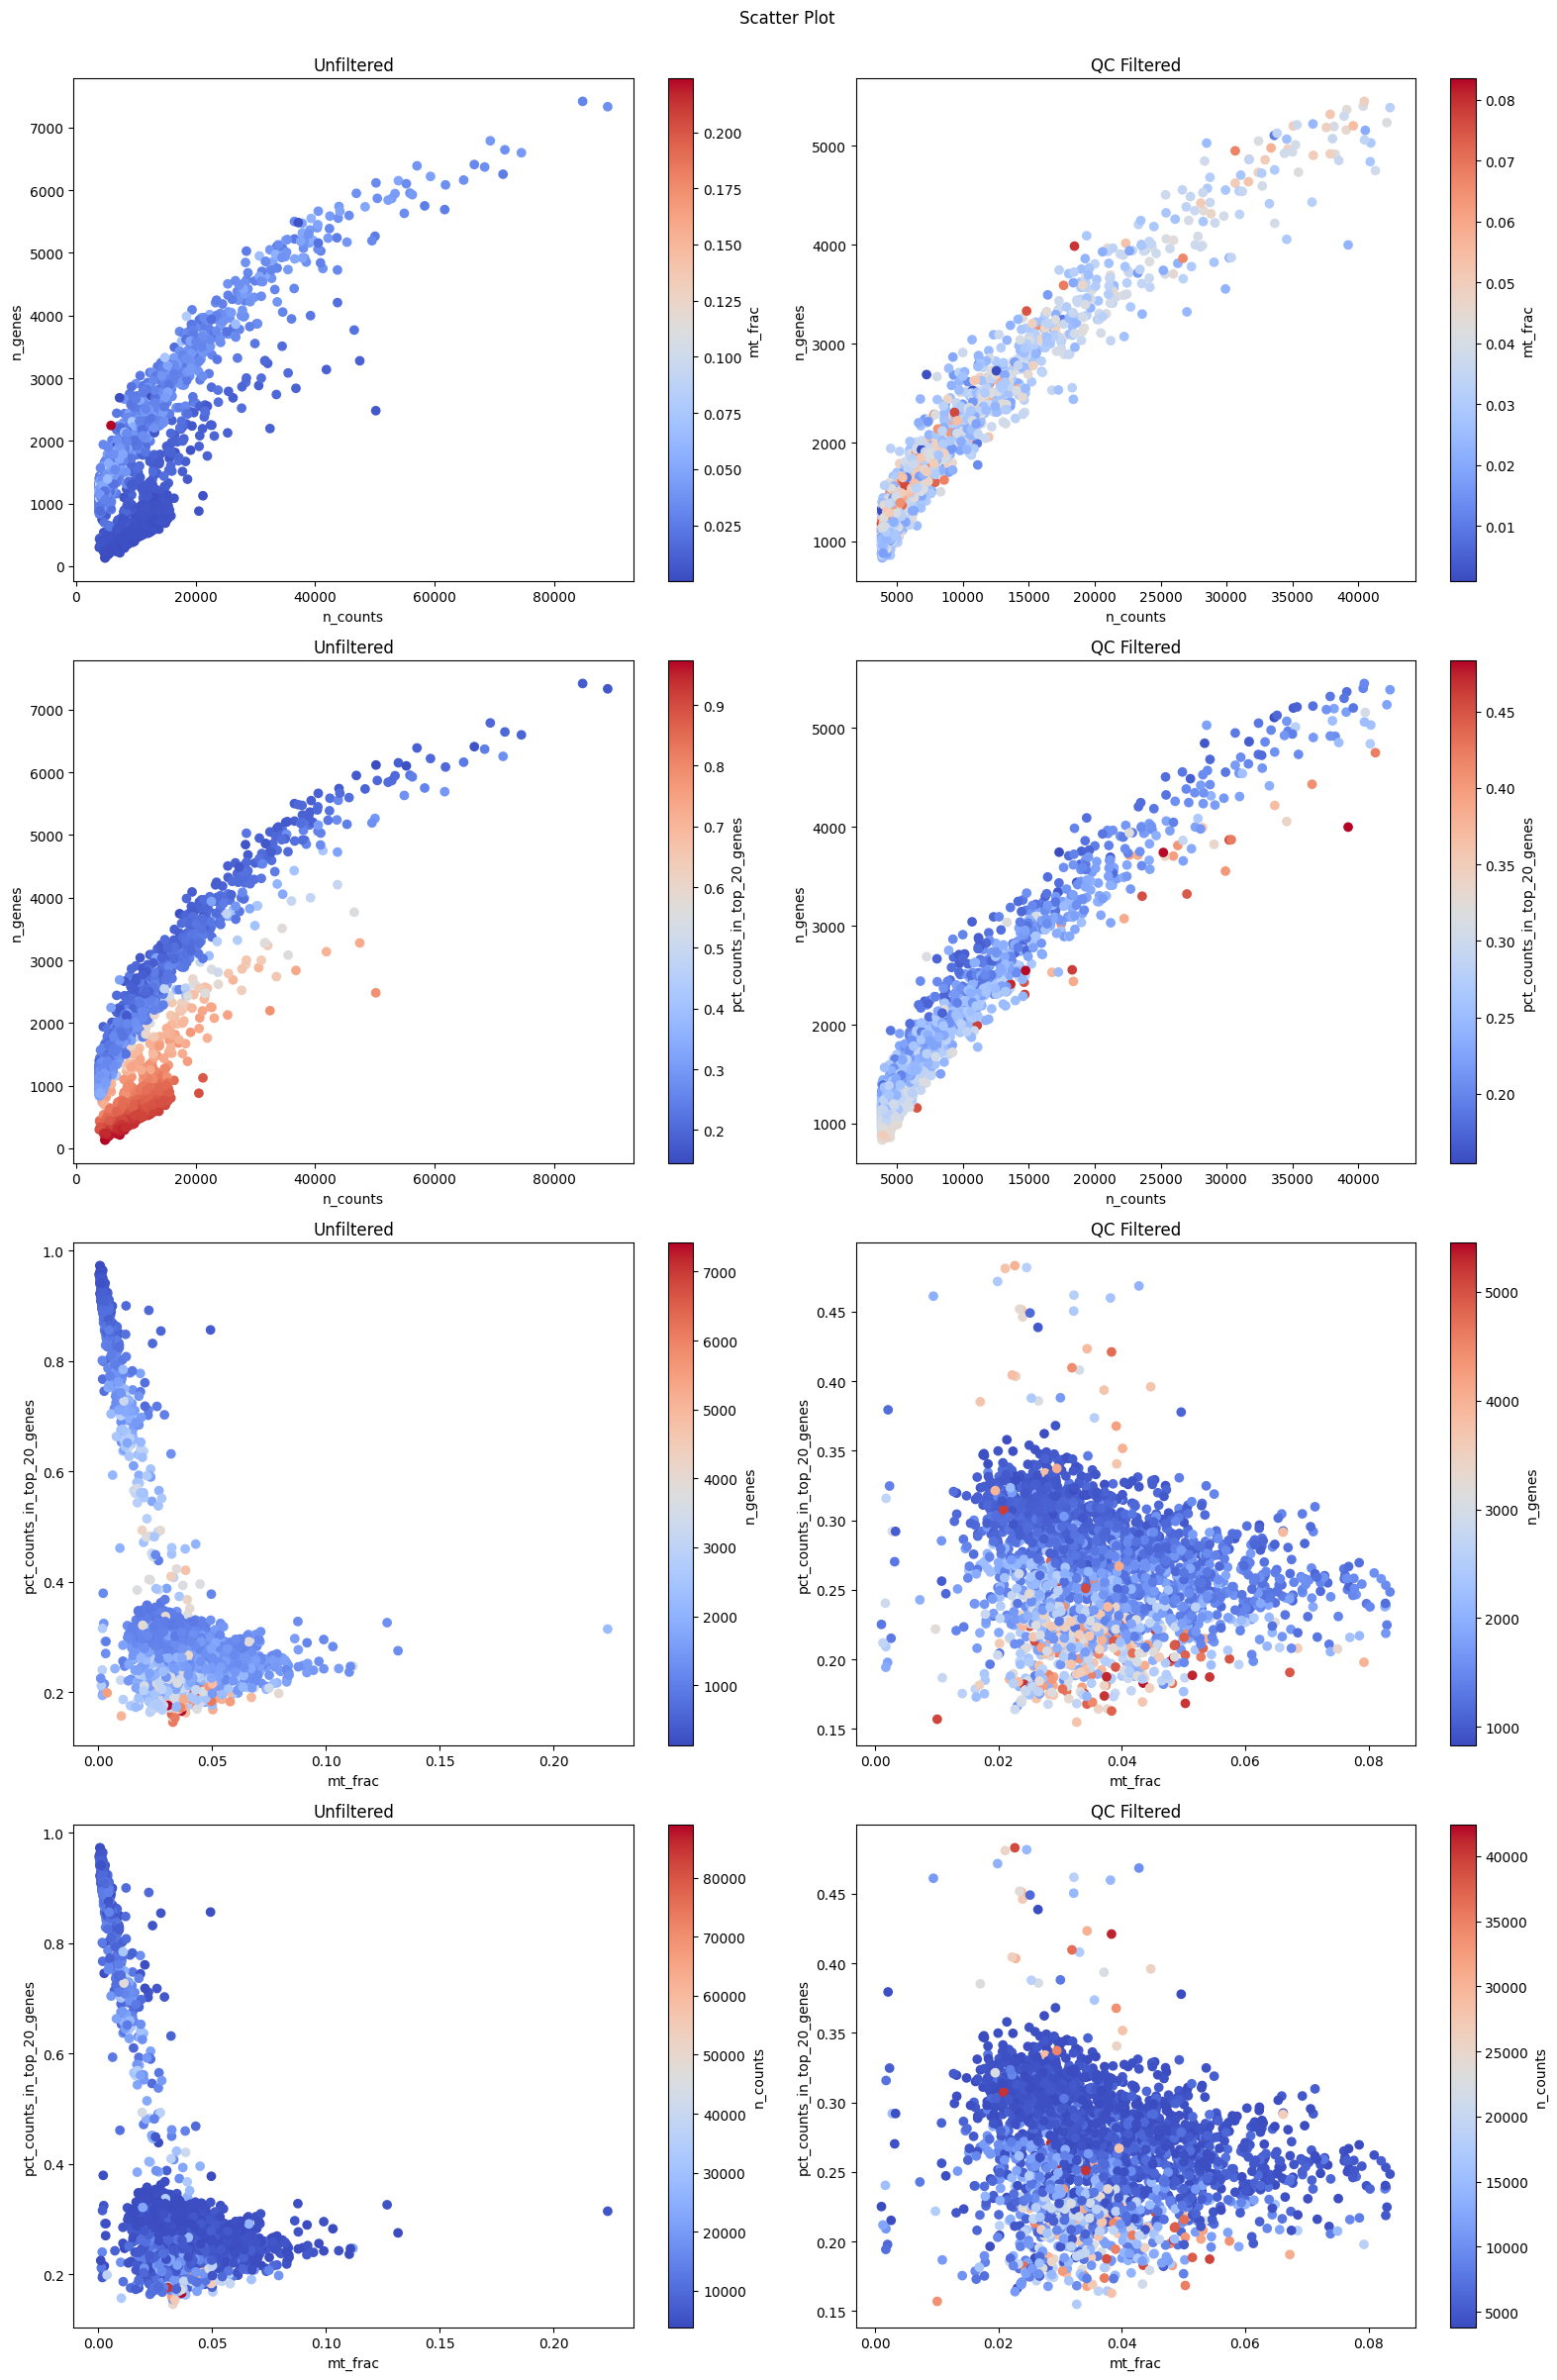

In [6]:
dp.EDA().ScatterForQCMetrics([adata, qc_adata],
                            title="Scatter Plot",
                            subtitle=["Unfiltered", "QC Filtered"])

## Normalize

In [7]:
norm_qc_adata = dp.log1p_normalize(qc_adata)

In [10]:
norm_qc_adata

AnnData object with n_obs × n_vars = 2311 × 12438
    obs: 'n_counts', 'log_n_counts', 'n_genes', 'log_n_genes', 'pct_counts_in_top_20_genes', 'mt_frac', 'outlier', 'size_factors'
    var: 'gene_id', 'n_cells'
    layers: 'counts', 'log1p_counts'

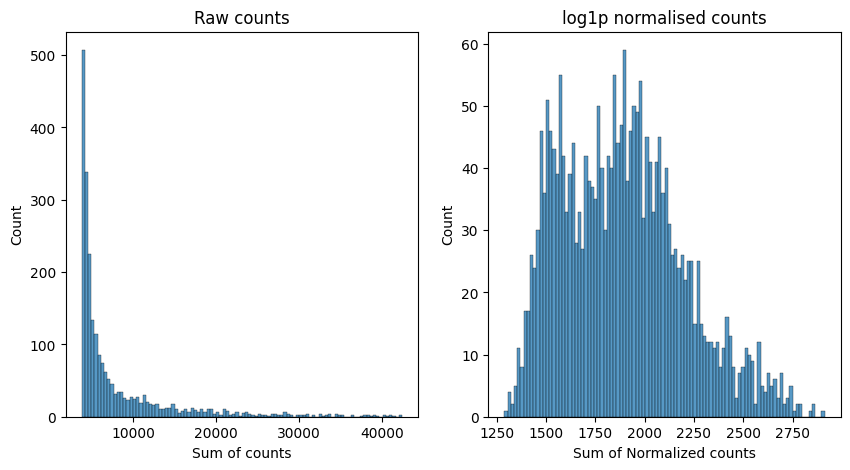

In [8]:
# Visualize counts before and after normalization
dp.EDA().VisualizeNormalization(norm_qc_adata)

In [26]:
# Download normalized count matrix
normalized_counts = pd.DataFrame(norm_qc_adata.layers["log1p_counts"])
normalized_counts.index = norm_qc_adata.obs.index.to_list()
normalized_counts.columns = norm_qc_adata.var.index.to_list()
normalized_counts.to_csv("text.csv")

## Highly Variable Genes

In [12]:
sc.pp.highly_variable_genes(norm_qc_adata, n_top_genes=4000, flavor="cell_ranger")
norm_qc_adata
norm_qc_adata.var

,gene_id,n_cells,highly_variable,means,dispersions,dispersions_norm
gene_symbol,,,,,,
FO538757.2,ENSG00000279457,252,False,0.079389,0.788659,0.403849
AP006222.2,ENSG00000228463,106,False,0.028734,0.725425,-0.597424
RP11-206L10.9,ENSG00000237491,82,False,0.023661,0.806264,0.348048
LINC00115,ENSG00000225880,51,False,0.014766,0.786916,0.022211
FAM41C,ENSG00000230368,129,False,0.038802,0.786664,0.202072
...,...,...,...,...,...,...
MT-CYB,ENSG00000198727,2308,False,3.156334,0.067166,-2.415806
AL592183.1,ENSG00000273748,401,True,0.140581,0.808011,1.387838
AC007325.4,ENSG00000278817,97,False,0.024754,0.710895,-0.765742


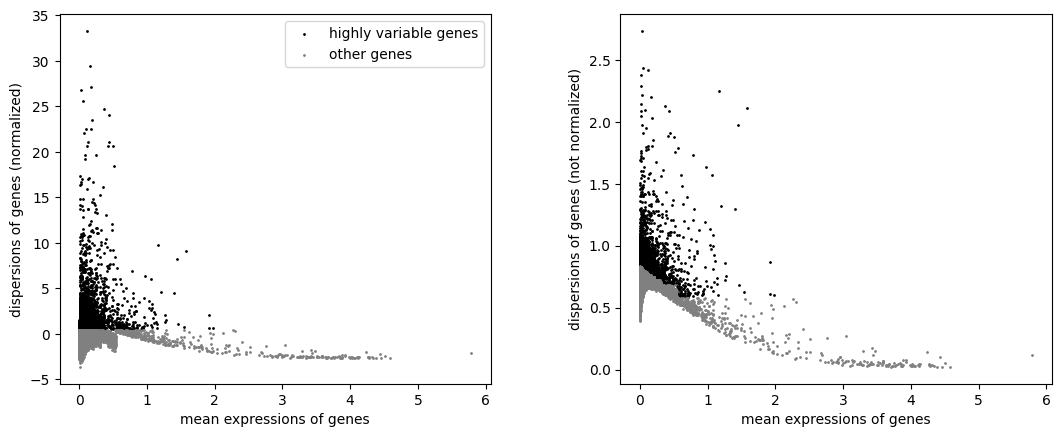

In [13]:
# Visualize highly variable genes
sc.pl.highly_variable_genes(norm_qc_adata)

## Clustering & Visualize

In [35]:
sc.pp.pca(norm_qc_adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(norm_qc_adata)
sc.tl.umap(norm_qc_adata)

# Use Leiden clustering
sc.tl.leiden(norm_qc_adata, resolution=1.0, key_added='leiden_res1')
sc.tl.leiden(norm_qc_adata, resolution=0.5, key_added='leiden_res0.5', random_state=16)
sc.tl.leiden(norm_qc_adata, resolution=0.25, key_added="leiden_res0.25", random_state=16)

c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



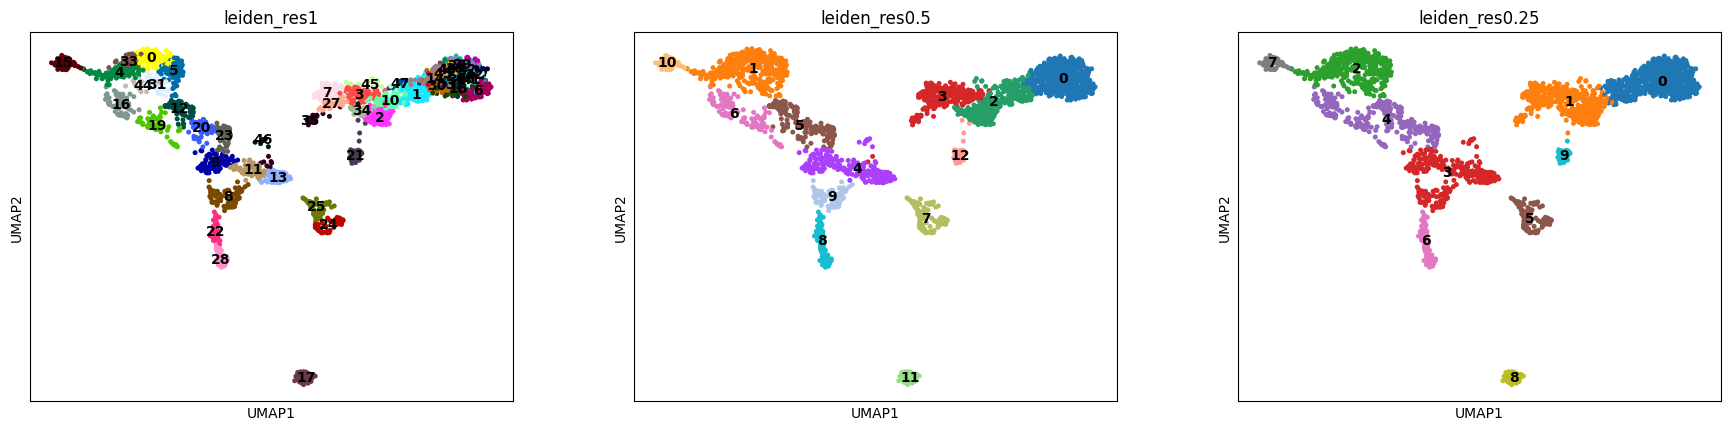

In [36]:
# Visualize the Leiden clustering
sc.pl.umap(norm_qc_adata,color=["leiden_res1", "leiden_res0.5", "leiden_res0.25"],legend_loc="on data",)

In [16]:
# Identify differentially expressed genes in each cluster
sc.tl.rank_genes_groups(norm_qc_adata, groupby='leiden_res1', key_added='rank_genes_res1', method='wilcoxon')#wilcoxon t-test_overestim_var

c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


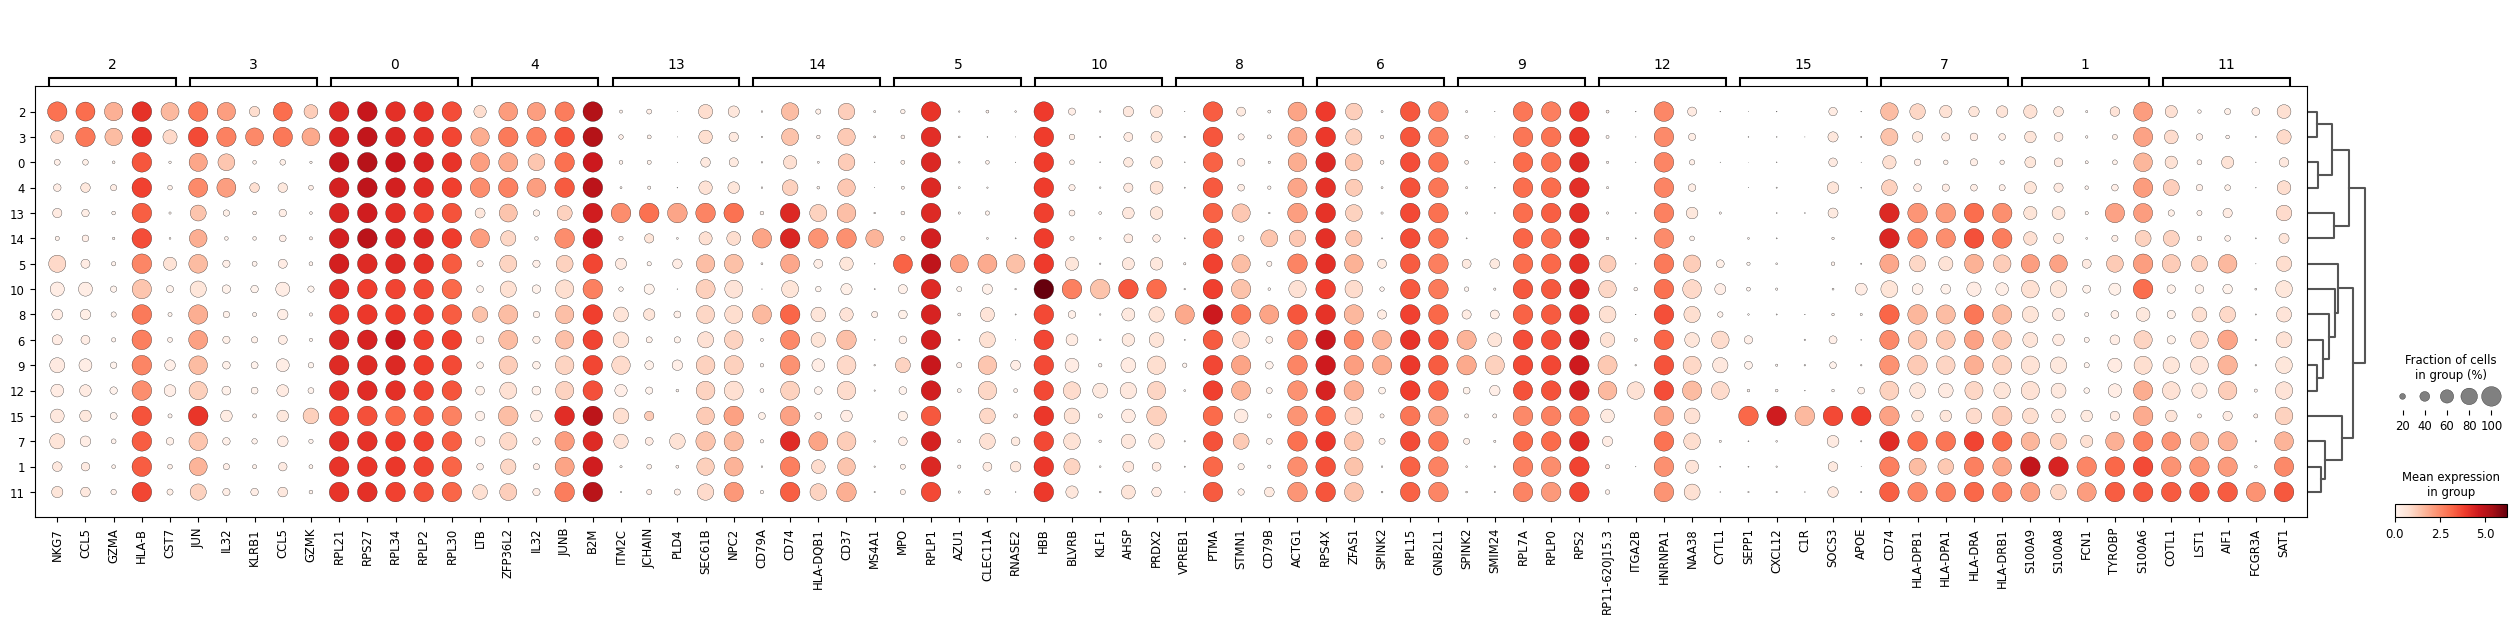

In [17]:
sc.pl.rank_genes_groups_dotplot(norm_qc_adata, n_genes=5, key="rank_genes_res1", groupby="leiden_res1")

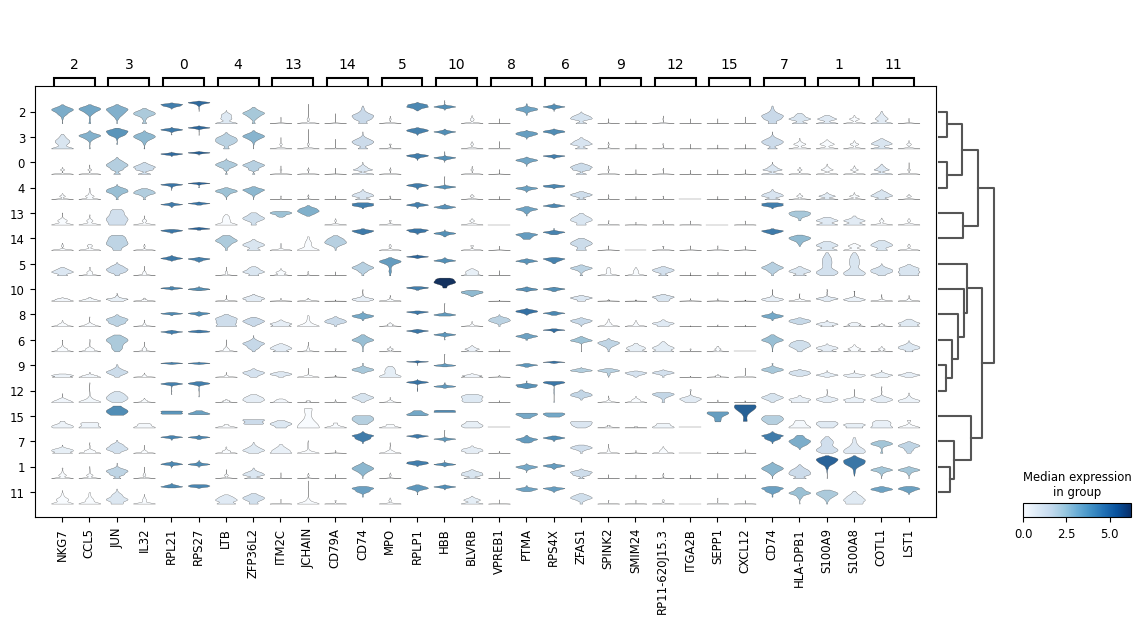

In [18]:
sc.pl.rank_genes_groups_stacked_violin(norm_qc_adata, n_genes=2, key="rank_genes_res1", groupby="leiden_res1")

In [39]:
norm_qc_adata

AnnData object with n_obs × n_vars = 2311 × 12438
    obs: 'n_counts', 'log_n_counts', 'n_genes', 'log_n_genes', 'pct_counts_in_top_20_genes', 'mt_frac', 'outlier', 'size_factors', 'leiden_res1', 'leiden_res0.5', 'leiden_res0.25'
    var: 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_res1_colors', 'leiden_res0.5_colors', 'leiden_res0.25_colors', 'rank_genes_res1', 'dendrogram_leiden_res1'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log1p_counts'
    obsp: 'distances', 'connectivities'

In [42]:
# Load immune cell gene markers
# '../../../../data/PanglaoDB_gene_markers/processed/human_immune_gene_markers.json'
# '../../../../data/CellMarker_gene_markers/processed/human_bone_marrow_markers.json'
with open('../../../../data/PanglaoDB_gene_markers/processed/human_immune_gene_markers.json', 'r') as json_file:
    Immune_markers_dict = json.load(json_file)

cell_annotation = sc.tl.marker_gene_overlap(norm_qc_adata, Immune_markers_dict, key='rank_genes_res1')

cell_annotation_norm = sc.tl.marker_gene_overlap(norm_qc_adata, Immune_markers_dict, key='rank_genes_res1', normalize='reference')

In [44]:
import plotly.graph_objs as go

# Assuming df is your DataFrame
data = cell_annotation_norm.values.tolist()

# Create a custom hover text with cell values
hover_text = [['Value: {:.2f}'.format(val) for val in row] for row in data]

# Create a heatmap trace with annotations
heatmap = go.Heatmap(
    z=data,
    colorscale='Viridis',
    hovertext=hover_text,
    colorbar=dict(title='Colorbar Title')
)

# Create the layout with a custom figure size
layout = go.Layout(
    width=800,  
    height=800, 
    xaxis=dict(tickmode='array', tickvals=list(range(len(cell_annotation_norm.columns))), ticktext=cell_annotation_norm.columns),
    yaxis=dict(tickmode='array', tickvals=list(range(len(cell_annotation_norm.index))), ticktext=cell_annotation_norm.index),
    title='Annotated Heatmap'
)

# Create the figure
fig = go.Figure(data=[heatmap], layout=layout)

# Show the plot
fig.show()

In [22]:
# Categories to rename
norm_qc_adata.obs['cell_type1'] = norm_qc_adata.obs['louvain_res1']
norm_qc_adata.rename_categories('cell_type1', ['T cells, 1', 'T+NK, 1', 'Monocytes, 1', 'Unknown, 1', 'Unknown, 2', 'T cells, 2', 'Erytro, 1', 'Erytro, 2', 'Erytro, 3', 'B cells, 2', 'Osteocytes, 1', 'Unknown, 3', 'Osteocytes, 2', 'Plasmacytoid dendritic cells', 'B cells, 1', 'Plasma cells', 'NK'])


KeyError: 'louvain_res1'